In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import lightgbm as lgb
import shap

In [4]:
# Load the dataset and drop 'medal_sum' directly
file_path = "C:/Users/Rishi/Downloads/final_dataset_clusters-2.csv"
df = pd.read_csv(file_path)

In [5]:
# Creating weighted score as the target variable
df['weighted_score'] = (df['gold'] * 3) + (df['silver'] * 2) + (df['bronze'] * 1)

# Dropping unnecessary columns, including medal counts
df_numeric = df.drop(columns=["country", "updated_country", "Country Code (ISO 3166-1 alpha-3)","gold", "silver", "bronze", "total"])

# Selecting features and target variable
x = df_numeric.drop(columns=['weighted_score'])
y = df_numeric['weighted_score']

# Define K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to evaluate with K-Fold
def evaluate_lightgbm_model(x, y, model, kf):
    train_r2_scores = []
    test_r2_scores = []
    train_rmse_scores = []
    test_rmse_scores = []

    for train_index, test_index in kf.split(x):
        X_train_cv, X_test_cv = x.iloc[train_index], x.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        # Apply Robust Scaling to features
        scaler_robust = RobustScaler()
        X_train_robust = scaler_robust.fit_transform(X_train_cv)
        X_test_robust = scaler_robust.transform(X_test_cv)

        # Apply Normalization to the scaled data
        scaler_minmax = MinMaxScaler()
        X_train_scaled = scaler_minmax.fit_transform(X_train_robust)
        X_test_scaled = scaler_minmax.transform(X_test_robust)

        # Train the model
        model.fit(X_train_scaled, y_train_cv, eval_set=[(X_test_scaled, y_test_cv)], eval_metric='rmse', callbacks=[lgb.early_stopping(50)])

        # Predictions
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        # Calculate R² and RMSE for train and test sets
        train_r2 = r2_score(y_train_cv, y_train_pred)
        test_r2 = r2_score(y_test_cv, y_test_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train_cv, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test_cv, y_test_pred))

        # Store results
        train_r2_scores.append(train_r2)
        test_r2_scores.append(test_r2)
        train_rmse_scores.append(train_rmse)
        test_rmse_scores.append(test_rmse)

    # Return mean of scores
    return np.mean(train_r2_scores), np.mean(test_r2_scores), np.mean(train_rmse_scores), np.mean(test_rmse_scores)

# Initialize LightGBM model
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    n_estimators=1000,
    force_col_wise=True
)

# Evaluate with K-Fold
mean_train_r2, mean_test_r2, mean_train_rmse, mean_test_rmse = evaluate_lightgbm_model(x, y, lgb_model, kf)

# Printing results
print("LightGBM Model Performance (With K-Fold, Dropping Medal Columns):")
print(f"Mean Train R2: {mean_train_r2}")
print(f"Mean Test R2: {mean_test_r2}")
print(f"Mean Train RMSE: {mean_train_rmse}")
print(f"Mean Test RMSE: {mean_test_rmse}")

[LightGBM] [Info] Total Bins 2175
[LightGBM] [Info] Number of data points in the train set: 336, number of used features: 22
[LightGBM] [Info] Start training from score 35.690476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

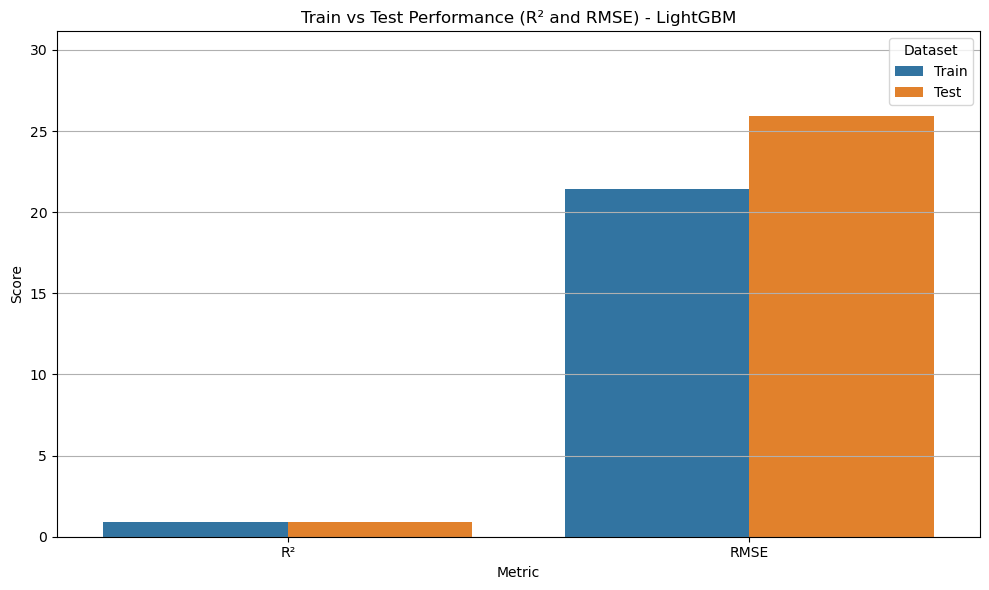

In [8]:
# Prepare data for plotting
metrics_df = pd.DataFrame({
    'Metric': ['R²', 'R²', 'RMSE', 'RMSE'],
    'Dataset': ['Train', 'Test', 'Train', 'Test'],
    'Score': [mean_train_r2, mean_test_r2, mean_train_rmse, mean_test_rmse]
})

# Plotting the comparison between Train and Test R² and RMSE
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Dataset', data=metrics_df)
plt.title('Train vs Test Performance (R² and RMSE) - LightGBM')
plt.ylim(0, 1.2 * max(mean_train_rmse, mean_test_rmse, mean_train_r2, mean_test_r2))  # Adjust the y-axis
plt.legend(title='Dataset')
plt.grid(axis='y')
plt.tight_layout()
plt.show()